# North Atlantic Hurricane Basin Predictor

![alt text](USA_zones.png)
<center>(Figure 1) Hurricane Zones</center>

Import modules

In [124]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

Import data

In [29]:
df = pd.read_csv('./data_preprocessed.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

Set independent and dependent variables

In [30]:
# df = df.sample(5000)
X = df.drop(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K'], axis=1)
y = df[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']]

Split data into training and test sets

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    shuffle=True)

### Zone "G"

Balancing classes and standardize independent variables

Balancing classes greatly improved F1 score

In [32]:
# Oversamping 'hits' to balance classes
ros = RandomOverSampler(random_state=42)
X_trainG, y_trainG = ros.fit_sample(X_train, y_train.G)    
scaler = StandardScaler()
X_trainG = scaler.fit_transform(X_trainG)
X_test = scaler.transform(X_test)

Baseline for a storm striking zone "G" (Southern Florida)

In [46]:
1 - y.G.sum() / y.G.count()

0.9022985412068687

The classes aren't balanced with 90.2% of storm events missing zone "G"

#### Preliminary models

In [58]:
clf = LogisticRegression()
print(cross_val_score(clf, X_trainG, y_trainG, cv=3, n_jobs=-1).mean())
print(cross_val_score(clf, X_trainG, y_trainG, scoring='f1', cv=3, n_jobs=-1).mean())

0.8838431436595542
0.8898292576669243


In [59]:
clf = RandomForestClassifier()
print(cross_val_score(clf, X_trainG, y_trainG, cv=3, n_jobs=-1).mean())
print(cross_val_score(clf, X_trainG, y_trainG, scoring='f1', cv=5, n_jobs=-1).mean())

0.98554233795429
0.9911740368662739


In [60]:
clf = SVC()
print(cross_val_score(clf, X_trainG, y_trainG, cv=3, n_jobs=-1).mean())
print(cross_val_score(clf, X_trainG, y_trainG, scoring='f1', cv=3, n_jobs=-1).mean())

0.950254104581568
0.9523775999981928


In [61]:
clf = KNeighborsClassifier()
print(cross_val_score(clf, X_trainG, y_trainG, cv=3, n_jobs=-1).mean())
print(cross_val_score(clf, X_trainG, y_trainG, scoring='f1', cv=3, n_jobs=-1).mean())

0.9237868387596752
0.9289466307402189


In [62]:
clf = AdaBoostClassifier()
print(cross_val_score(clf, X_trainG, y_trainG, cv=3, n_jobs=-1).mean())
print(cross_val_score(clf, X_trainG, y_trainG, scoring='f1', cv=3, n_jobs=-1).mean())

0.7950494839451377
0.79643759762963


After at glance at the different classifiers, Random Forest jumps out as a strong candidate

#### Random Forest

In [57]:
parms = {
    'n_estimators': [46],
    'max_depth': [97],
}
model = RandomForestClassifier()
clf = GridSearchCV(model, parms, cv=5, scoring='f1', n_jobs=-1, verbose=1, error_score=0)
clf.fit(X_trainG, y_trainG)
print(clf.best_score_,
      clf.best_estimator_)
print('Test evaluation: ',
      metrics.f1_score(y_test.G, clf.predict(X_test)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.7s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


0.9973197320594679 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=97, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=46, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Test evaluation:  0.7715665976535542


Overfit the random forest model

#### K-Nearest Neighbors

In [65]:
parms = {
    'n_neighbors': [1],
    'p': [2]
}
model = KNeighborsClassifier()
clf = GridSearchCV(model, parms, cv=5, scoring='f1', n_jobs=-1, verbose=1, error_score=0)
clf.fit(X_trainG, y_trainG)
print(clf.best_score_,
      clf.best_estimator_)
# print('Test evaluation: ',
#       metrics.f1_score(y_test.G, clf.predict(X_test)))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


0.9672498719538147 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')


In [83]:
model = KNeighborsClassifier(n_neighbors=1, p=2)
clf = model.fit(X_trainG, y_trainG)
print('Test evaluation: ',
      metrics.f1_score(y_test.G, clf.predict(X_test)))

Test evaluation:  0.785793562708102


Overfit KNN model

#### Logistic Regression

In [68]:
parms = {
    'C': np.linspace(28, 40, 2)
}
model = LogisticRegression()
clf = GridSearchCV(model, parms, cv=5, scoring='f1', n_jobs=-1, verbose=1, error_score=0)
clf.fit(X_trainG, y_trainG)
print(clf.best_score_,
      clf.best_estimator_)
# print('Test evaluation: ',
#       metrics.f1_score(y_test.G, clf.predict(X_test)))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   16.1s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.0s finished


0.8895556900704447 LogisticRegression(C=28.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [ ]:
model = LogisticRegression(C=28)
clf = model.fit(X_trainG, y_trainG)
print('Test evaluation: ',
      metrics.f1_score(y_test.G, clf.predict(X_test)))

Test evaluation:  0.45248349124318116


Logistic regression did not perform well

#### Support Vector Machine

In [76]:
parms = {
    'kernel': ['rbf'],
    'C': range(1, 25, 5)
}
model = SVC()
clf = GridSearchCV(model, parms, cv=3, scoring='f1', n_jobs=-1, verbose=1, error_score=0)
clf.fit(X_trainG, y_trainG)
print(clf.best_score_,
      clf.best_estimator_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   33.3s finished


0.9826985392073634 SVC(C=21, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [40]:
(12140 * 338) / df.shape[0]

110.4408677396781

##### PCA

Using PCA to reduce dataset in order to run support vector machine

In [25]:
pca = PCA(110)
X_trainG_pca = pca.fit_transform(X_trainG)
X_test_pca = pca.transform(X_test)
pca.explained_variance_ratio_.sum()

0.5973489282793063

In [73]:
parms = {
    'kernel': ['rbf'],
    'C': range(1, 25, 5)
}
model = SVC()
clf = GridSearchCV(model, parms, cv=3, scoring='f1', n_jobs=-1, verbose=1, error_score=0)
clf.fit(X_trainG_pca, y_trainG)
print(clf.best_score_,
      clf.best_estimator_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   18.7s finished


0.9909662835140575 SVC(C=11, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [14]:
%%time
model = SVC(kernel='rbf', C=11)
clf = model.fit(X_trainG_pca, y_trainG)
print('Test evaluation: ',
      metrics.f1_score(y_test.G, clf.predict(X_test_pca)))

Test evaluation:  0.3868954758190328
CPU times: user 27.6 s, sys: 104 ms, total: 27.7 s
Wall time: 27.7 s


SVC takes too long to train...it showed great promise

PCA + kNN

In [35]:
%%time
for n in range(10, 220, 10):
    pca = PCA(n)
    X_trainG_pca = pca.fit_transform(X_trainG)
    X_test_pca = pca.transform(X_test)
    print('PCA: ', n)
    print('Explained variance: ', pca.explained_variance_ratio_.sum())
    clf = KNeighborsClassifier(1)
    clf.fit(X_trainG_pca, y_trainG)
    print('Test evaluation: ',
          metrics.f1_score(y_test.G, clf.predict(X_test_pca)))
    print('***')

PCA:  10
Explained variance:  0.20181484676527284
Test evaluation:  0.49914334665905197
***
PCA:  20
Explained variance:  0.2609654587023876
Test evaluation:  0.6058788242351529
***
PCA:  30
Explained variance:  0.3065430570103831
Test evaluation:  0.7292753623188406
***
PCA:  40
Explained variance:  0.3391886414211598
Test evaluation:  0.7348993288590604
***
PCA:  50
Explained variance:  0.3729982715655318
Test evaluation:  0.7511160714285714
***
PCA:  60
Explained variance:  0.4056478554292573
Test evaluation:  0.7512520868113522
***
PCA:  70
Explained variance:  0.43771313298742


KeyboardInterrupt: 

Curse of dimensionality appears to not have a significant effect

In [37]:
%%time
model = KNeighborsClassifier(n_neighbors=1, p=2)
clf = model.fit(X_trainG, y_trainG)
preds = clf.predict(X_test)
print('Test evaluation: ',
      metrics.f1_score(y_test.G, preds))

Test evaluation:  0.785793562708102
CPU times: user 2min 4s, sys: 40 ms, total: 2min 4s
Wall time: 2min 4s


In [40]:
print(metrics.classification_report(y_test.G, preds, target_names=['Miss', 'Hit']))

             precision    recall  f1-score   support

       Miss       0.98      0.97      0.98      8410
        Hit       0.77      0.81      0.79       879

avg / total       0.96      0.96      0.96      9289



In [45]:
print(metrics.confusion_matrix(y_test.G, preds))

[[8195  215]
 [ 171  708]]


# Training all Zones with kNN (k=1)

In [65]:
model = {}
Xtrain = {}
Xtest = {}
ytrain = {}
ytest = {}
baseline = {}
preds = {}
f1_scores = {}
for zone in 'ABCDEFGHIJK':
    print('*** Zone: ', zone, ' ***')
    df = pd.read_csv('./data_preprocessed.csv')
    df.drop('Unnamed: 0', axis=1, inplace=True)
#     df = df.sample(5000)
    X = df.drop(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K'], axis=1)
    y = df[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']]
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        shuffle=True)
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_sample(X_train, y_train[zone])    
    scaler = StandardScaler()
    X_train_resampled_ss = scaler.fit_transform(X_train_resampled)
    X_test_ss = scaler.transform(X_test)
    model[zone] = KNeighborsClassifier(1).fit(X_train_resampled_ss, y_train_resampled)
    Xtrain[zone] = X_train_resampled_ss
    ytrain[zone] = y_train_resampled
    Xtest[zone] = X_test_ss
    ytest[zone] = y_test[zone]
    baseline[zone] = 1 - y[zone].sum() / y[zone].count()
    preds[zone] = model[zone].predict(Xtest[zone])
    f1_scores[zone] = metrics.f1_score(ytest[zone], preds[zone])
    print(zone, f1_scores[zone])

*** Zone:  A  ***
A 0.7521739130434782
*** Zone:  B  ***
B 0.7532751091703057
*** Zone:  C  ***
C 0.7692307692307693
*** Zone:  D  ***
D 0.7508417508417509
*** Zone:  E  ***
E 0.7922998986828773
*** Zone:  F  ***
F 0.7784615384615384
*** Zone:  G  ***
G 0.7846153846153847
*** Zone:  H  ***
H 0.8015303682448588
*** Zone:  I  ***
I 0.8203445447087776
*** Zone:  J  ***
J 0.8124658283214871
*** Zone:  K  ***
K 0.8102643856920684


In [67]:
import pickle
pickle.dump(model, open("knn_1.p", "wb"))
pickle.dump(f1_scores, open("knn_1_f1.p", "wb"))

Let's see if a neural nets improve our results

In [126]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import Adam
from keras.initializers import *

In [355]:
zone = 'G'
model = Sequential()
input_units = Xtrain[zone].shape[1]
hidden_units = input_units
model.add(Dense(hidden_units,
                input_dim=input_units,
                activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(hidden_units + 30,
                activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(12,
                activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [356]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [362]:
hist = model.fit(Xtrain[zone],
                 ytrain[zone],
                 validation_data=(Xtest[zone], ytest[zone]),
                 epochs=15,
                 batch_size=256,
                 shuffle=True)

Train on 53564 samples, validate on 7431 samples
Epoch 1/15
53564/53564 [==============================] - 2s 38us/step - loss: 0.0085 - acc: 0.9972 - val_loss: 0.0170 - val_acc: 0.9962
Epoch 2/15
53564/53564 [==============================] - 2s 38us/step - loss: 0.0068 - acc: 0.9978 - val_loss: 0.0168 - val_acc: 0.9960
Epoch 3/15
53564/53564 [==============================] - 2s 37us/step - loss: 0.0081 - acc: 0.9974 - val_loss: 0.0166 - val_acc: 0.9962
Epoch 4/15
53564/53564 [==============================] - 2s 37us/step - loss: 0.0069 - acc: 0.9979 - val_loss: 0.0133 - val_acc: 0.9962
Epoch 5/15
53564/53564 [==============================] - 2s 37us/step - loss: 0.0070 - acc: 0.9979 - val_loss: 0.0168 - val_acc: 0.9958
Epoch 6/15
53564/53564 [==============================] - 2s 40us/step - loss: 0.0064 - acc: 0.9979 - val_loss: 0.0109 - val_acc: 0.9972
Epoch 7/15
53564/53564 [==============================] - 2s 38us/step - loss: 0.0052 - acc: 0.9985 - val_loss: 0.0102 - val_acc:

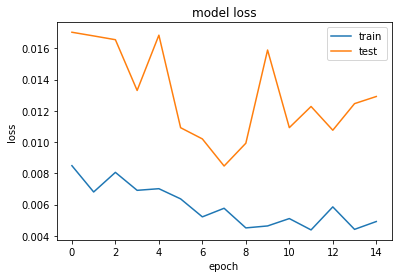

In [363]:
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best') ## I love this loc = 'best' command.
plt.show()

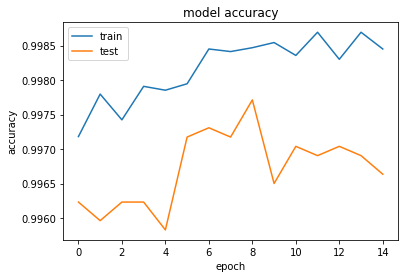

0.9966357152469385

In [364]:
plt.figure()
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
hist.history['val_acc'][-1]

In [366]:
print('Test evaluation: ', metrics.f1_score(ytest[zone],
                                            np.round(model.predict(Xtest[zone]))))

Test evaluation:  0.9817916970138383
